In this notebook, we're going to use Pytorch to train a linear regression model. 

This task won't be exploring the real power of deep neural networks (we won't have any hidden layers so it's not "deep" and it can't represent nonlinear relationships in the data.

The code, however, is very much similar to what deep neural network code looks like, that is, most of the code you use here you will be useful when writing code for a deep neural network. 

This task just helps get you familiar with the main steps of defining and training a neural network in Pytorch.

We'll start by importing PyTorch and its related packages 

In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# set default device based on CUDA's availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cpu'

We'll generate a synthetic dataset with known parameters so we can test if out Linear Regression Neural Network model will find the same parameters (which means close enough parameters since the model can't find the exact same parameters due to numerical precision)

Do note that the target variable we're predicting is not the exact same as the function we have defined. This is because we inject Gaussian noise to the target variable Why? Because when observing a variable in the real world there's always a chance for observation error (like taking measurements using a microscope). We account for those changes (noise) by adding random numbers to each example, sampled from a normal (Gaussian) distrubution.

We here choose a mean of 0 and a standard deviation of 0.1. Which means we multiply the output of torch.randn (which has a mean of 0 and a standard deviation of 1) by 0.1.

**Q1: Define the X, Y and noise variables**

In [2]:
num_inputs = 2 #Number of features we'll generate
num_outputs = 1 #We only have one output
num_examples = 10_000 #We'll generate 10,000 examples
dtype = torch.float

#Define a function with 2 and -3.4 as parameters, 4.2 as bias
def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2

#TODO: Generate training dataset consisting of random numbers
#Use torch.randn to generate an array of shape (num_examples, num_inputs)
X = torch.randn(num_examples, num_inputs)


#TODO: Add some Gaussian noise to the dataset
#Use torch.randn to generate an array of shape (num_examples)
#Multiply that array by 0.1 to change the standard deviation of the noise to .1
noise = torch.randn(num_examples) * 0.1
#TODO: Generate target variable using our function and the noise
# y is the output of applying real_fn to X and adding the noise
# Also reshape y to be of shape (-1, 1)
y = (real_fn(X)+noise).reshape(-1, 1)


Now we can inspect the values of our training dataset and target variable, as well the true function we're predicting (without the added noise)

In [3]:
print(X[0]) #Sample from training set
print(y[0]) #Corresponding target variable
print(2 * X[0, 0] - 3.4 * X[0, 1] + 4.2) #Actual function value


tensor([-0.4716,  0.1632])
tensor([2.8440])
tensor(2.7020)


We can also plot our training dataset against the target variable

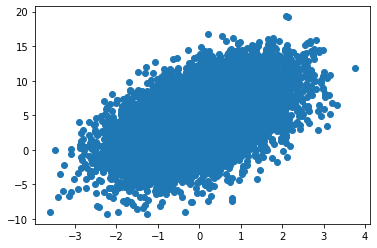

In [4]:
plt.scatter(X[:, 0].cpu().numpy(), y.cpu().numpy())
plt.show()

Next we'll define a very simple class to load the data, it loads the data, then defines the `__len__` method to get its size and the `__getitem__` method to get a single example and its ground truth

In [5]:
class LinearDataset(Dataset):
    def __init__(self, X, y):
        assert X.size()[0] == y.size()[0]
        self.X = X
        self.y = y
    
    def __len__(self):
        return X.size()[0]
    
    def __getitem__(self, idx):
        return [X[idx], y[idx]]


We'll use PyTorch's `DataLoader` class to generate the dataloader for our training data. We give it as input an instance of our dataset and specify the `batch_size` and set `shuffle=True` so that it provides batches in random order. 

In [6]:
batch_size = 4
train_dataloader = DataLoader(LinearDataset(X, y), batch_size=batch_size, shuffle=True)


We can now loop through the dataloader to get batches of data at each iteration. 

In [7]:
for i, (data, label) in enumerate(train_dataloader):
    print(data)
    print(label)
    break


tensor([[ 0.6365, -0.7384],
        [-1.5601, -0.2775],
        [ 0.5768,  0.6184],
        [-0.2560, -0.3388]])
tensor([[8.0119],
        [1.9523],
        [3.3534],
        [4.9453]])


Do note that each time we loop through the data, it will have different order. That's because we've set shuffle=True. This helps the model become more robust as it gets batches in a different order in each epoch (pass through the training data so it reduces overfitting.

In [8]:
for i, (data, label) in enumerate(train_dataloader):
    print(data)
    print(label)
    break


tensor([[-1.1466, -0.7623],
        [ 1.0321, -1.6122],
        [ 0.6980, -1.4215],
        [ 1.4459,  0.1429]])
tensor([[ 4.4065],
        [11.7944],
        [10.3629],
        [ 6.5146]])


If we count how many iterations we go through in train_dataloader we find that it does 2500 iterations. That's because we have a total of 10,000 examples and a `batch_size` of 4. Changing the batch size should affect the number of iterations, which are generally `number of examples / batch_size`

In [9]:
counter = 0
for i, (data, label) in enumerate(train_dataloader):
    pass
print(i + 1)


2500


**Q2: Define the Linear Regression model using Pytorch**

In [10]:
class LinearRegression(nn.Module):
    def __init__(self, **kwargs):
        super(LinearRegression, self).__init__(**kwargs)
        #TODO: Use torch's nn.Linear to define a Linear layer 
        #The layer should have an input of shape 2 and an output of shape 1 
        self.dense_1 = nn.Linear(2, 1)
        
    def forward(self, x):
        #TODO: Call the self.dense_1 you just defined on x
        x = self.dense_1(x)
        return x
    
net = LinearRegression()#TODO: Instantiate the LinearRegression class you just defined
net.to(device)


LinearRegression(
  (dense_1): Linear(in_features=2, out_features=1, bias=True)
)

**Q3: Use Mean Squared Error loss**

In [11]:
loss_fn = nn.MSELoss() #TODO: use nn.MSELoss for the loss function


**Q4: Use Stochastic Gradient Descent for optimizing the model**

In [13]:
optimizer = optim.SGD(net.parameters(), lr= 1e-5,momentum=0.9)#TODO: Use optim.SGD with learning rate = 1e-5 and a momentum of 0.9

**Q5: Complete the training loop and train the model**

In [27]:
epochs = 10
num_batches = num_examples / batch_size
losses = []

for epoch in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_dataloader):
        data = data.to(device)
        label = label.to(device)
        
        yhat = net(data)
        loss = loss_fn(yhat, label) #TODO: Call the loss function you defined earlier
        
        #TODO: Call the zero_grad method of the optimizer you defined
        #TODO: Call the backward method of the loss tensor you just calculated
        #TODO: Call the step method of the optimizer 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cumulative_loss += loss.item()
    print("Epoch %s, loss: %s" % (epoch, cumulative_loss / num_examples))
    losses.append(cumulative_loss / num_batches)


Epoch 0, loss: 5.558315691265464
Epoch 1, loss: 2.045522131574154
Epoch 2, loss: 0.7538032941907644
Epoch 3, loss: 0.27881831742767244
Epoch 4, loss: 0.10414453657148406
Epoch 5, loss: 0.039897078270092604
Epoch 6, loss: 0.01628271130514331
Epoch 7, loss: 0.007600375100154633
Epoch 8, loss: 0.004411281857496943
Epoch 9, loss: 0.0032367374833658685


Now we can plot the average loss of the model for each epoch it trained.

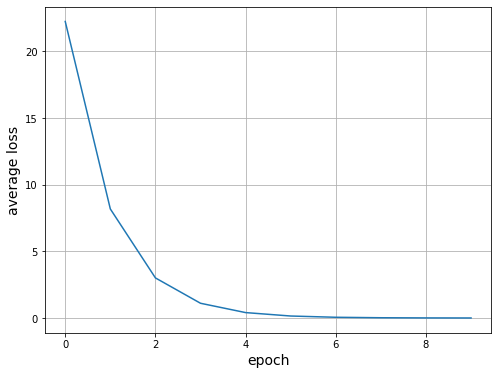

In [28]:
plt.figure(num=None, figsize=(8, 6))
plt.plot(losses)

plt.grid(True, which="both")
plt.xlabel('epoch', fontsize=14)
plt.ylabel('average loss', fontsize=14)
plt.show()


Finally we print the parameters of the model. Notice that while it didn't get the exact values we'd set (2,-3.4, and 4.2). It got very close. Of course this is becuase this is a synthetic dataset that's completely linear. Real-life datasets are never this clean, but this serves as a demonstration and introduction to Pytorch and how it can model Linear Regression.

In [29]:
params = net.parameters()
print('The type of "params" is a ', type(params))

for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.data)


The type of "params" is a  <class 'generator'>
dense_1.weight tensor([[ 1.9899, -3.3731]])
dense_1.bias tensor([4.1711])


Attribution: This task is based on this [notebook](https://github.com/Kulbear/pytorch-the-hard-way/blob/master/Linear%20Regression.ipynb).